# 1. Инициализация окружения
В качестве итогового проекта решаем задачу классификации на наборе данных [Fashion-MNIST](https://www.kaggle.com/zalando-research/fashionmnist)
## Загрузка библиотек

In [1]:
# tensorflow должна быть не ниже 1.13.0rc0
import tensorflow as tf
# numpy должна быть не ниже 1.16.1
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

## Загрузка данных
### C помощью класса `fashion_mnist` по сети

train: (60000, 28, 28) (60000,)
test:  (10000, 28, 28) (10000,)
train: (60000, 784) (60000, 10)
test:  (10000, 784) (10000, 10)


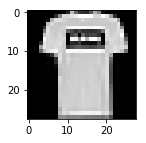

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Нормализация
x_train = x_train / 256
x_test = x_test / 256

# Начальный датасет
print("train:", x_train.shape, y_train.shape)
print("test: ", x_test.shape, y_test.shape)

# Выводим 1 изображение
plt.figure(figsize=(2,2))
plt.gray()
plt.imshow(x_train[1])

# Преобразуем код одежды в one-hot представление
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

# Изменяем размерность массива маски
x_train = x_train.reshape(len(x_train), 28 ** 2)
x_test = x_test.reshape(len(x_test), 28 ** 2)

# Результат преобразований
print("train:", x_train.shape, y_train.shape)
print("test: ", x_test.shape, y_test.shape)

### Из локальной директории

Если не удалось загрузить файлы по сети, то можно загрузить их локально.  
Скачиваем набор данных `Fashion-MNIST`, распаковываем в 1 директорию:
* t10k-images-idx3-ubyte
* t10k-labels-idx1-ubyte
* train-images-idx3-ubyte
* train-labels-idx1-ubyte

При необходимости устанавливаем пакет `python-mnist`.

In [0]:
from mnist import MNIST

# '.\data' - директория в которой находятся файлы для загрузки
# Нужно указать самостоятельно
mndata = MNIST('.\data')

# Загружаем
x1_train, y1_train = mndata.load_training()
x1_test, y1_test = mndata.load_testing()

# Преобрзуем список в массив NumPy
x1_train, y1_train = np.array(x1_train), np.array(y1_train)
x1_test, y1_test = np.array(x1_test), np.array(y1_test)

print("train:", x1_train.shape, y1_train.shape)
print("test: ", x1_test.shape, y1_test.shape)

train: (60000, 784) (60000,)
test:  (10000, 784) (10000,)


## Вспомогательный класс `SimpleModel`

Т.к. все последующие вычисления будут реализованы с помощью `keras`, то имеет смысл вынести общие части в 1 место что бы не дублировать код.

In [3]:
class SimpleModel:
    def __init__(self, epochs, batch_size=None, verbose=0):
#         Количество эпох
        self.epochs = epochs
#         Информативность лога при расчете: 
#             0 - ничего не выводить, 
#             1 - самый полный 
#             ... 
#             3 - минимальный
        self.verbose = verbose
#         Размер порции данных для обучения
        self.batch_size = batch_size
#         Результат работы метода fit
        self.hist_df = pd.DataFrame()
        self.model = keras.models.Sequential()

#     Добавление слоя
    def add(self, layer_obj):
        self.model.add(layer_obj)

#     Добавление слоя
    def compile(self):
#         Компилируем модель
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=keras.optimizers.SGD(momentum=0.9),
                           metrics=['accuracy'],
                          )
        
#     Обучение модели
    def fit(self, x, y, validation_data=None, callbacks=None):
        hist = self.model.fit(x, y,
                              batch_size=self.batch_size,
                              epochs=self.epochs,
                              verbose=self.verbose,
                              validation_data=validation_data,
                              callbacks=callbacks,
                            )
#         Сохраняем историю в датафрейм
        self.hist_df = pd.DataFrame()
        for name in filter(lambda x: x in hist.history.keys(), ['acc', 'val_acc']):
            self.hist_df.insert(len(self.hist_df.columns), 
                                name, 
                                hist.history[name])
#         Увеличиваем индексы на 1 => индексы начинаются с 1, а не с 0
        if not self.hist_df.empty:
            self.hist_df.index +=1

#     Оценка точности модели
    def accuracy(self, x, y, verbose=0):
        loss, accuracy = self.model.evaluate(x, y, verbose=0)
        if verbose:
            print('accuracy:', accuracy)
        else:
            return accuracy
    

## Процедура вывода графика

In [43]:
def prn_graph(df, title, x_axis=None):
    legend = ['Тренировочнае', 'Тестовые']
    if x_axis is not None:
        df = df.loc[x_axis,]
    for name in filter(lambda x: x in df.columns, ['acc', 'val_acc']):
        plt.plot(df[name])
    plt.title(title)
    plt.ylabel('Точность')
    plt.xlabel('Эпоха')
    plt.legend(legend)
    plt.show()        


## Класс, прерывающий обучение при снижении точности модели
* `monitor` - оценивается точность работы модели на тестовых данных `val_acc`
* `patience` - количество снижений подряд прежде чем процесс обучения будет остановлен
* `restore_best_weights` - появилось в `tensorflow` версии `1.13`, восстанавливает веса из самой точной модели

In [5]:
def gen_stop_callback():
    return keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=15,
                                         restore_best_weights=True)


## Класс `TensorBoard`, визуализация обучения

In [6]:
def get_tensorboard():
    return keras.callbacks.TensorBoard()


## 1.5 Параметры обучения модели
Для всех моделей будут использоваться один набор данных, причины выбора именно этих значений можно узнать в самом низу нуотбука. 
Один набор позволить сравнить точность моделей при одних и тех же параметрах, а так же при необходимости попробовать подобрать параметры позволящие, если не улучшить качество, то хотя бы уменьшить время обучения

In [7]:
class Param:
    # количество выходных классов
    num_classes = 10

    # Максимальное количество эпох при обучении
    epochs=1000

    # объем выводимой информации в логе
    verbose=0

# 1. Логистическая регрессия

Для решения задачи классификации предлагается начать с использования логистической регрессии. В данном случае, количество признаков равно 28x28=784, так же мы имеем 60000 объектов в тренировочной выборке. Поэтому рекомендуется использовать `tensorflow` или `keras` для выполнения этого задания. Используйте стохастический градиентный спуск (`stochastic gradient descent`) в качестве алгоритма оптимизации.

По своей сути, логистическая регрессия может быть реализована как нейронная сеть без скрытых слоев. В выходном слое содержится количество нейронов, равное количеству классов. В качестве функции активации выходного слоя следует использовать `softmax`.

Обучите логистическую регрессию на тренировочной выборке и оцените качество на тестовой выборке используя метрику `accuracy`. Постройте график качества модели на валидационной выборке от количества эпох. Для этого вы можете использовать утилиту `tensorboard`.

In [8]:
# Метод возвращающий модель
def gen_log_model(epochs, batch_size=None):
    model = SimpleModel(epochs, batch_size=batch_size, verbose=Param.verbose)
    model.add(keras.layers.Dense(Param.num_classes, activation='softmax', input_shape=(784,)))
    model.compile()
    return model


## 1.1 Точность модели

In [9]:
log_model = gen_log_model(Param.epochs)
log_model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              callbacks=[gen_stop_callback(), get_tensorboard()]
             )
# Почистим вывод от лишней информации
clear_output()

log_accuracy = log_model.accuracy(x_test, y_test)
print(f"accuracy: {log_accuracy}")

accuracy: 0.8449000120162964


## 1.2 Визуализация с помощью `matplotlib`

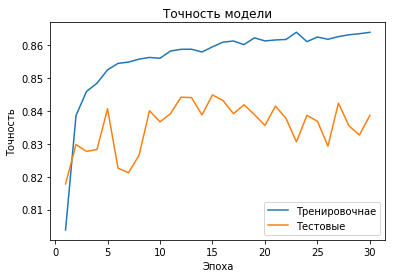

In [44]:
prn_graph(log_model.hist_df, 'Точность модели')

## 1.3 Визуализация с помощью `TensorBoard`
Для запуска веб-интерфейса на локальном компьютере нужно выполнить в команной строке команду:  
`tensorboard --logdir==.\log --host=127.0.0.1`  
`.\log` - полный путь к каталогу с логами созданными `tensorboard_callback`
Если расчеты запускаются на удаленной машине, то `--host=127.0.0.1` можно опустить  
[Веб-интерфейс на локальной машине](http://127.0.0.1:6006)

# 2. Полносвязная нейронная сеть
Полносвязная нейронная сеть с несколькими скрытыми слоями. 
Как изменилось качество в сравнении с логистической регрессией? 
Как можно объяснить этот результат?

In [11]:
def get_hopfield(epochs, batch_size=None):
    model = SimpleModel(epochs, batch_size=batch_size)
    model.add(keras.layers.Dense(32, activation='relu', input_shape=(784,)))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(Param.num_classes, activation='softmax'))
    model.compile()
    return model


## 2.1 Точность модели

In [12]:
hopfield = get_hopfield(Param.epochs)
hopfield.fit(x_train, y_train,
             validation_data=(x_test, y_test),
             callbacks=[gen_stop_callback()]
            )

hopf_accuracy = hopfield.accuracy(x_test, y_test)
print(f"accuracy: {hopf_accuracy}")

accuracy: 0.8805999755859375


In [16]:
print(f"{log_accuracy:.2%} точность логистической регрессии")
print(f"{hopf_accuracy:.2%} точность полносвязанной сети")

84.49% точность логистической регрессии
88.06% точность полносвязанной сети


Точность полносвязанной сети должна превышать точность логистической регрессии, как минимум потому что полносвязанная сеть представляет собой более сложную струкутуру, которая позволяет более точно вычислять весовые коэффициенты

# 3. Сверточная нейронная сеть
Модели с несколькими сверточными слоями. 


In [17]:
# Преобразуем данные 
x_train_pixel = x_train.reshape(len(x_train), 28, 28, 1)
x_test_pixel  = x_test.reshape(len(x_test), 28, 28, 1)


## 3.1 Используются слои суб-дискретизации,
Например `Max Pooling` слои. Они понижают размерность исходных данных и выделяют наиболее важные признаки из данных. Посчитайте качество получившейся модели на тестовой выборке. Сравните полученные результаты с результатами полносвязной нейронной сети.

In [30]:
def get_sub_layers(epochs, batch_size=None):
    model = SimpleModel(epochs, batch_size=batch_size)

    model.add(keras.layers.Convolution2D(32, 
                                         kernel_size=(3,3), 
                                         input_shape=(28,28, 1),
                                         activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(Param.num_classes, activation='softmax'))
    model.compile()
    return model


### 3.1.1 Точность модели

In [31]:
sub_layers = get_sub_layers(Param.epochs)
sub_layers.fit(x_train_pixel, y_train,
               validation_data=(x_test_pixel, y_test),
               callbacks=[gen_stop_callback()]
              )

sub_accuracy = sub_layers.accuracy(x_test_pixel, y_test)
print(f"accuracy: {sub_accuracy}")


accuracy: 0.9132000207901001


Добавление слоев суб-дискретизации позволило получить более точную модель при более простой структуре модели (по сложности вычислений в модели)

In [46]:
print(f"{hopf_accuracy:.2%} точность полносвязанной сети")
print(f"{sub_accuracy:.2%} точность сверточной сети")

88.06% точность полносвязанной сети
91.32% точность сверточной сети


## 3.2 Увеличенное количество слоев

In [37]:
def get_sub_layers_big(epochs, batch_size=None):
    model = SimpleModel(epochs, batch_size=batch_size)

    model.add(keras.layers.Convolution2D(32, 
                                         kernel_size=(3,3), 
                                         input_shape=(28,28, 1),
                                         activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Convolution2D(64, 
                                         kernel_size=(3,3), 
                                         activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Convolution2D(128, 
                                         kernel_size=(3,3), 
                                         activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(Param.num_classes, activation='softmax'))
    model.compile()
    return model


### 3.2.1 Точность модели

In [48]:
sub_layers_big = get_sub_layers_big(Param.epochs)
sub_layers_big.fit(x_train_pixel, y_train,
                   validation_data=(x_test_pixel, y_test),
                   callbacks=[gen_stop_callback()]
                  )

subbig_accuracy = sub_layers_big.accuracy(x_test_pixel, y_test)
print(f"accuracy: {subbig_accuracy}")


accuracy: 0.88919997215271


Точность модели снизилось, возможно это связано с неверным выбором параметров модели

## 3.3  Добавление Batch Normalization слоев
Обычно они располагаются после сверточных слоев или слоев полносвязной нейронной сети. Обычно они улучшают качество модели, этим объясняется их популярность использования в современных архитектурах нейронных сетей.

In [39]:
def get_batch_norm(epochs, batch_size=None):
    model = SimpleModel(epochs, batch_size=batch_size)

    model.add(keras.layers.Conv2D(32,
                                  kernel_size=(3,3), 
                                  input_shape=(28,28, 1),
                                  activation='relu',
                                 ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32,
                                  kernel_size=(3,3), 
                                  input_shape=(28,28, 1),
                                  use_bias=False,
                                 ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(64,
                                  kernel_size=(3,3), 
                                  input_shape=(28,28, 1),
                                  activation='relu',
                                 ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64,
                                  kernel_size=(3,3), 
                                  input_shape=(28,28, 1),
                                  use_bias=False,
                                 ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(32, activation='relu',use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(Param.num_classes, activation='softmax'))
    model.compile()
    return model



### 3.3.1 Точность модели

In [41]:
batch_norm = get_batch_norm(Param.epochs)
batch_norm.fit(x_train_pixel, y_train,
               validation_data=(x_test_pixel, y_test),
               callbacks=[gen_stop_callback()]
              )

clear_output()

batch_norm_accuracy = batch_norm.accuracy(x_test_pixel, y_test)
print(f"accuracy: {batch_norm_accuracy}")


accuracy: 0.9279000163078308


# 4. Сводная таблица по всем моделям

In [49]:
print(f"{log_accuracy:.2%} точность логистической регрессии")
print(f"{hopf_accuracy:.2%} точность полносвязанной сети")
print(f"{sub_accuracy:.2%} точность сверточной сети")
print(f"{subbig_accuracy:.2%} точность с увеличенным количеством слоев суб-дискртизации")
print(f"{batch_norm_accuracy:.2%} точность модели с batch-нормализацией")


84.49% точность логистической регрессии
88.06% точность полносвязанной сети
91.32% точность сверточной сети
88.92% точность с увеличенным количеством слоев суб-дискртизации
92.79% точность модели с batch-нормализацией


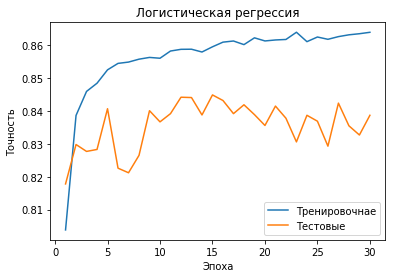

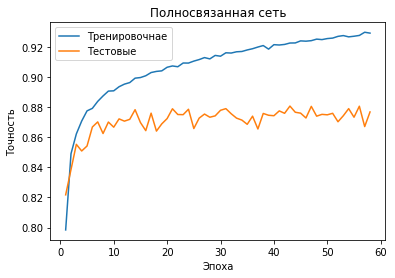

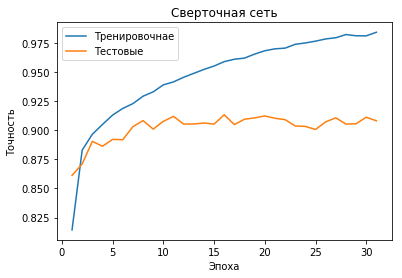

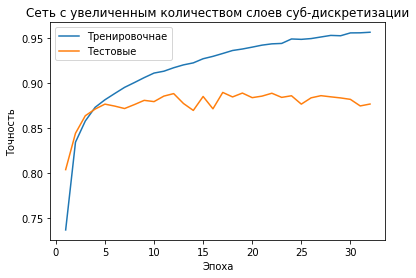

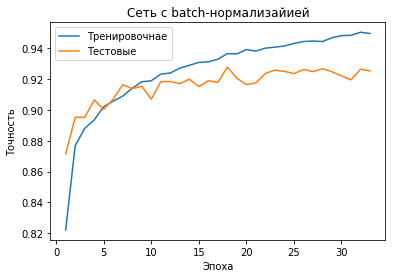

In [50]:
prn_graph(log_model.hist_df, 'Логистическая регрессия')
prn_graph(hopfield.hist_df, 'Полносвязанная сеть')
prn_graph(sub_layers.hist_df, 'Сверточная сеть')
prn_graph(sub_layers_big.hist_df, 'Сеть с увеличенным количеством слоев суб-дискретизации')
prn_graph(batch_norm.hist_df, 'Сеть с batch-нормализайией')